In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Linear Interpolation 
def ends_filler(column):
    if  column.dtype.kind in ['i', 'f']:
            column = first_filler(column)
            column = last_filler(column)
    return column

def first_filler(column):
    if pd.isnull(column.at[0]) or np.isnan(column.at[0]):
        size = len(column) -1
        first_valid_index = 0
        while first_valid_index <= size and (pd.isnull(column.at[first_valid_index]) or np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > size:
            column.at[0] = 0.0
        else:
            column.at[0] = column.at[first_valid_index]
    return column
    
def last_filler(column):
    if pd.isnull(column.at[len(column) -1]) or np.isnan(column.at[len(column) -1]):  
        last_valid_index = len(column) -1
        while last_valid_index >= 0 and (pd.isnull(column.at[last_valid_index]) or np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < 0:
            column.at[len(column) -1] = 0.0
        else:
            column.at[len(column) -1] = column.at[last_valid_index]
    return column
    
def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def linear_filler(column):
    if column.isnull().any():
        for i, value in enumerate(column):
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                linear_a = (column.at[end] - column.at[start])/(end - start)
                linear_b = column.at[start] - linear_a*start
                for x in gap:
                    column.at[x] = linear_a*x + linear_b
    return column 


In [4]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = ends_filler(df[col])
                df[col] = linear_filler(df[col]) 
            i += 1
        return df

In [5]:
df = read_csv_replace_missing_by_polynomial('nfsp_fluxo_mensal_corrente.csv', 0)
df_porcentagem = read_csv_replace_missing_by_polynomial('nfsp_porcentagem_pib.csv', 0)
df['NFSP - Porcentagem do PIB (%)'] = df_porcentagem.iloc[:, 1]


In [6]:
def plot_column(column, color):
    plt.figure(figsize=(12, 6))
    plt.plot(column.index, column.values, color=color)
    plt.xlabel(column.index.name)
    plt.ylabel('y')
    plt.title(column.name)  # Set the column name as the graph title
    plt.xticks(rotation=45)
    plt.show()

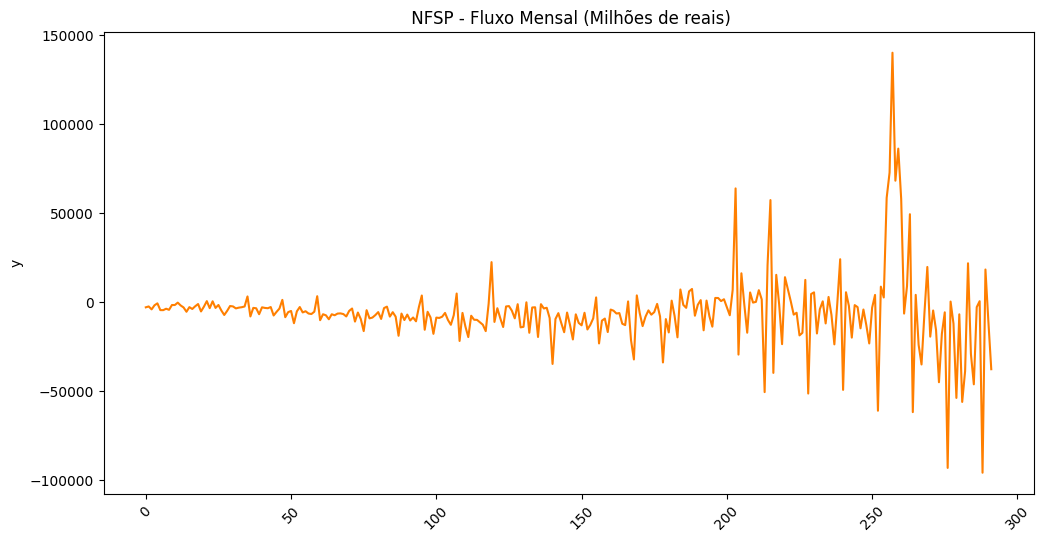

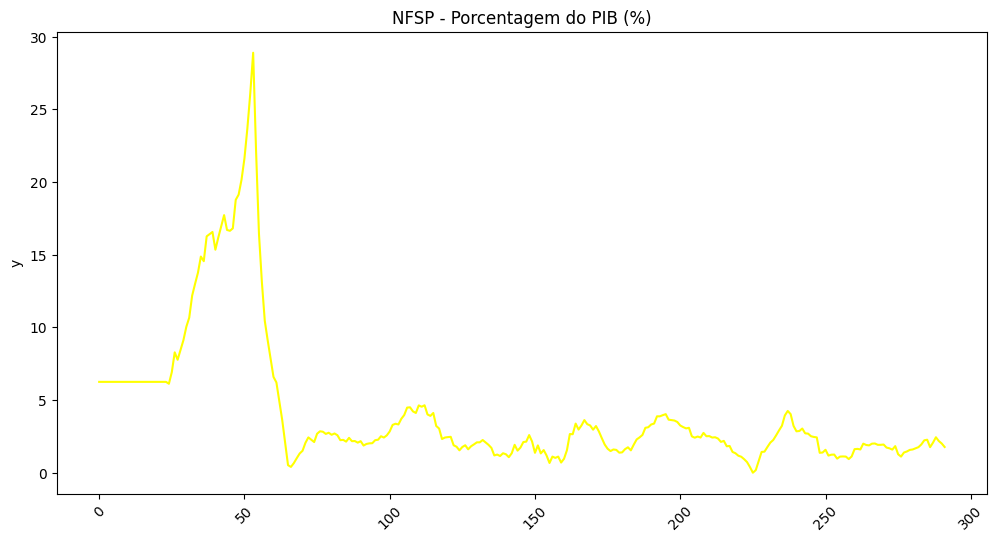

In [7]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF',
          '#00FFFF', '#008000', '#800000', '#808000', '#008080', '#800080', '#FF4500', '#FFD700', '#ADFF2F',
          '#32CD32', '#87CEEB', '#6A5ACD', '#BA55D3', '#EE82EE', '#FF69B4', '#FFA500', '#FF8C00', '#7FFFD4',
          '#00CED1']

for i, column in enumerate(df.columns):
    if i > 0:
        plot_column(df[column], color=colors[i])

In [8]:
def centered_moving_average(column, window_action, window_size):
    
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)
    moving_averages = []

    for i in range(start_index, end_index + 1):
        start = max(0, i - window_size)
        end = min(data_length, i + window_size + 1)
        window = data[start:end]
        moving_averages.append(np.mean(window))
        
    modified_data = data.copy()
    modified_data[start_index:end_index + 1] = moving_averages
    modified_column = pd.Series(modified_data, name=column.name)

    return modified_column

In [9]:
df_cma = df.copy()
for col in df_cma.columns:
    if col != 'index':  
        df_cma[col] = centered_moving_average(df_cma[col], (0,len(df_cma) - 1), 3)
df_cma

,data,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
0,1999,-2835.452500,6.250000
1,1999,-2413.456000,6.250000
2,1999,-2764.828333,6.250000
3,1999,-3018.478571,6.250000
4,1999,-3131.400000,6.250000
...,...,...,...
287,2022,-23711.335714,2.137143
288,2022,-24936.387143,2.071429
289,2022,-21388.450000,2.038333
290,2022,-25094.852000,2.094000


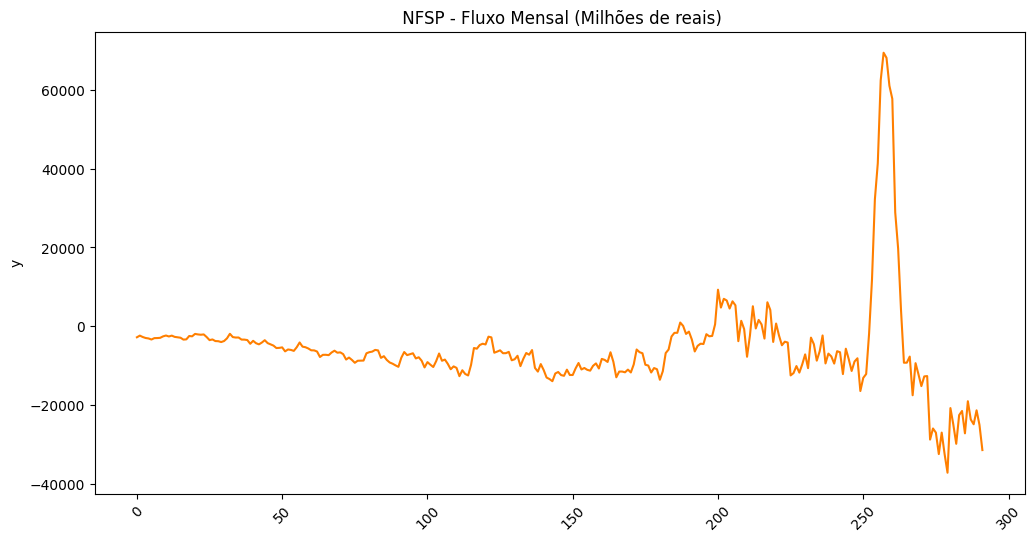

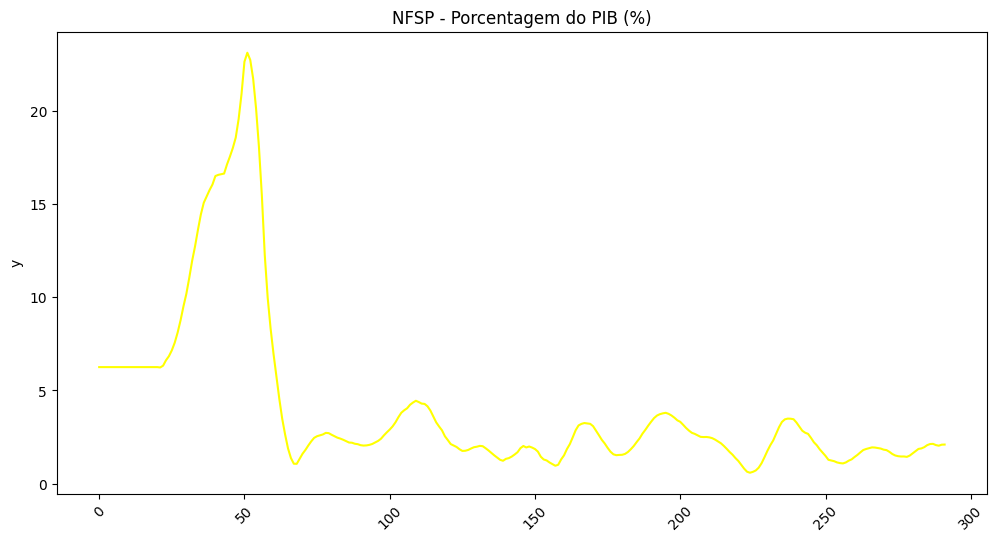

In [10]:
for i, column in enumerate(df.columns):
    if i > 0:
        plot_column(df_cma[column], color=colors[i])

In [11]:
df_ano = df_cma.groupby('data').mean()
df_ano = df_ano.rename_axis('Ano', axis='index')
df_ano

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
Ano,,
1999,-2814.940741,6.250000
2000,-2744.869762,6.517857
2001,-3289.328214,12.204167
2002,-4612.109167,18.043333
2003,-5767.980714,14.075595
2004,-7362.736548,1.922857
2005,-7676.435714,2.510000
2006,-8335.387976,2.195714
2007,-9528.398095,3.732381
